In [28]:
import torch
print(torch.cuda.is_available()) # Ha de ser True

False


# Overview

Can a computer "learn" to classify artists by their paintings? 

ResNet50 is a good model for classifying ImageNet data. How about a set of 38 artists?

We use transfer learning to re-train a ResNet50 model to identify one of 38 artists who have more than ***200*** paintings in the dataset. 

This notebook is part of a project for CSC 480 taught by [Dr. Franz J. Kurfess](http://users.csc.calpoly.edu/~fkurfess/) at Cal Poly

A web application is [in development](https://github.com/SomethingAboutImages/WebImageClassifier) to make use of the model that this notebook outputs. 

In [29]:
from PIL import Image
import os

# Original Directory
input_dir = "../our_code/train_1"

# Directory where the images will be saved
output_dir = "../our_code/train_1_rotated"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List of the input files
image_files = os.listdir(input_dir)

for img_file in image_files:
    img_path = os.path.join(input_dir, img_file)
    # Lettura dell'immagine originale
    try:img = Image.open(img_path)
    except IOError:
        print("Impossible to read the message:", img_path)
        continue
    


In [30]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# %matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info

import gc # garbage collection

In [31]:
MY_SEED = 42 # 480 could work too
seed(MY_SEED)
np.random.seed(MY_SEED)
tensorflow.random.set_seed(MY_SEED)

print(sys_info())
# get module information
# %pip freeze > frozen-requirements.txt
# append system information to file
# with open("frozen-requirements.txt", "a") as file:
#     file.write(sys_info())

{'commit_hash': '8b1204b6c',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': 'C:\\Users\\bdari\\AppData\\Roaming\\Python\\Python311\\site-packages\\IPython',
 'ipython_version': '8.21.0',
 'os_name': 'nt',
 'platform': 'Windows-10-10.0.22631-SP0',
 'sys_executable': 'c:\\Users\\bdari\\AppData\\Local\\Programs\\Python\\Python311\\python.exe',
 'sys_platform': 'win32',
 'sys_version': '3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC '
                'v.1934 64 bit (AMD64)]'}


In [32]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17710596438303329388
xla_global_id: -1
]


In [33]:
# https://stackoverflow.com/questions/25705773/image-cropping-tool-python
# because painting images are hella big
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

## Directories

In [34]:
# marta
# DATA_DIR = r"C:\Users\jesus\Desktop\Projecte"
# TRAIN_1_DIR = r"C:\Users\jesus\Desktop\Projecte\train_10_artists\train_10_artists"
#TRAIN_2_DIR = r"C:\Users\jesus\Desktop\Projecte\imatges\train_9\train_9"
# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
# TEST_DIR = r"C:\Users\jesus\Desktop\Projecte\test"

# marta azure
# DATA_DIR = '/home/xnmaster/Pictures'
# TRAIN_1_DIR = '/home/xnmaster/Pictures/train_10_artists/train_10_artists'
# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
# TEST_DIR = "/home/xnmaster/Pictures/test"

# mercè 
# DATA_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input" 
TRAIN_1_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input\train_10_selected_artists\train_10_selected_artists"
TEST_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input\test\test"
# TRAIN_1_DIR = "/home/xnmaster/Project/input/train_10_selected_artists"
# TEST_DIR = "/home/xnmaster/Project/input/test"
TRAIN_DIRS = [TRAIN_1_DIR]

# ariadna
DATA_DIR = "../../"
TRAIN_1_DIR = "../../train_10_selected_artists"
TEST_DIR = "../../test"
TRAIN_DIRS = [TRAIN_1_DIR]

#Daria
TRAIN_1_DIR = '../our_code/train_1'
TEST_DIR = '../our_code/test_1'
TRAIN_1_ROT_DIR = '../our_code/train_1_rotated'
TRAIN_DIRS = [TRAIN_1_DIR]


In [35]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_train = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_train)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_test = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_test)


Number of files in the folder TRAIN_1_DIR: 3838
Number of files in the folder TEST_DIR: 61


In [36]:
# df = pd.read_csv('/home/xnmaster/Pictures/all_data_info.csv') # r'\train_info\train_info.csv'
# df = pd.read_csv('/home/xnmaster/Project/input/all_data_info/all_data_info.csv')
# df = pd.read_csv(r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input\all_data_info\all_data_info.csv")
df = pd.read_csv("../all_data_info.csv/all_data_info.csv")
print("df.shape", df.shape)

df.shape (103250, 12)


In [37]:
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


Keep the works of artists who have a representation above x

In [38]:
# Count occurrences of each artist
# artist_counts = df['artist'].value_counts()

## Artists

In [39]:
train_df = df[df["in_train"] == True]
test_df = df[df['in_train'] == False]
train_df = df[['artist', 'new_filename']]
test_df = test_df[['artist', 'new_filename']]

print("test_df.shape", test_df.shape)
print("train_df.shape", train_df.shape)

test_df.shape (23817, 2)
train_df.shape (103250, 2)


In [40]:
artists = {'Camille Pissarro': 393,
 'Vincent van Gogh': 392,
 'Theophile Steinlen': 389,
 'Pierre-Auguste Renoir': 388,
 'Boris Kustodiev': 388,
 'Pyotr Konchalovsky': 388,
 'Gustave Dore': 387,
 'Edgar Degas': 387,
 'Camille Corot': 387,
 'Eugene Boudin': 387
}

In [41]:
training_set_artists = list(artists.keys())
training_set_artists

['Camille Pissarro',
 'Vincent van Gogh',
 'Theophile Steinlen',
 'Pierre-Auguste Renoir',
 'Boris Kustodiev',
 'Pyotr Konchalovsky',
 'Gustave Dore',
 'Edgar Degas',
 'Camille Corot',
 'Eugene Boudin']

In [42]:
t_df = train_df[train_df["artist"].isin(training_set_artists)]

t_df.head(5)

,artist,new_filename
28,Gustave Dore,7486.jpg
29,Gustave Dore,35766.jpg
34,Gustave Dore,31977.jpg
147,Edgar Degas,95360.jpg
279,Pierre-Auguste Renoir,85018.jpg


In [43]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## wandb
Execute following lines if we use wandb

In [44]:
# %pip install wandb -qU

In [45]:
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
wandb.login()

#wandb.login(relogin=True)

# 0927244f833ccea1b247099feaaaf54084a5c30c

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

## without wandb

### ResNet50

In [47]:
from tensorflow.keras import regularizers

class AdaptiveKernelRegularizer(regularizers.Regularizer):
    def __init__(self, initial_lambda=0.01, growth_rate=0.001):
        self.initial_lambda = initial_lambda
        self.growth_rate = growth_rate
        self.current_lambda = initial_lambda

    def __call__(self, x):
        regularization = self.current_lambda * tensorflow.reduce_sum(tensorflow.square(x))
        self.current_lambda += self.growth_rate  # Update the lambda adaptively
        return regularization

    def get_config(self):
        return {'initial_lambda': self.initial_lambda, 'growth_rate': self.growth_rate}


In [48]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))

model_adam.add(Dense(
  num_classes,
  activation='relu'))

model_adam.add(Dropout(0.4))  # Afegim una capa de Dropout amb una taxa de 0.5 per reduir l'overfitting
model_adam.add(Dense(
  num_classes,
  activation='softmax',
  kernel_regularizer=AdaptiveKernelRegularizer(0.01, 0.001) # learning rate adaptatiu
  # kernel_regularizer=l2(0.001)  # Afegim regularització L2 amb un factor de regularització de 0.01
))

model_adam.layers[0].trainable = False


In [49]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

IMAGE_SIZE = 224
num_classes = len(training_set_artists)

# Define the base model with ResNet50
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Build the model
model_adam = Sequential()
model_adam.add(base_model)
model_adam.add(GlobalAveragePooling2D())
model_adam.add(Dense(2048, activation='relu'))  # Aumentar el tamaño de la capa densa
model_adam.add(BatchNormalization())
model_adam.add(Dropout(0.5))
model_adam.add(Dense(1024, activation='relu', kernel_regularizer=AdaptiveKernelRegularizer(0.01, 0.0005)))  # Aumentar el tamaño de la capa densa y reducir L2 regularization
model_adam.add(BatchNormalization())
model_adam.add(Dropout(0.5))
model_adam.add(Dense(num_classes, activation='softmax'))

# Compile the model
# model_adam.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Display the model summary
# model_adam.summary()


# Compile Model

## Adam

### ResNet50

In [50]:
opti = tensorflow.keras.optimizers.Adam(learning_rate=0.01)
# gradient_accumulation_steps = 4 # 'optimitzador actualitzarà els paràmetres cada 4 passos, usant la mitjana dels gradients acumulats durant aquests 4 passos.

In [51]:
model_adam.compile(
  optimizer=opti, # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)
model_adam.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 4,465,664 (17.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

# Setup the image data generator for each training directory 

In [52]:
def batch_size(num_fitxers, max_batch_size=64):
    for size in range(max_batch_size, 0, -1):
        if num_fitxers % size == 0:
            return size
    return 1 

BATCH_SIZE = batch_size(num_files_in_train)
TEST_BATCH_SIZE = batch_size(num_files_in_test)

print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"TEST_BATCH_SIZE: {TEST_BATCH_SIZE}")


BATCH_SIZE: 38
TEST_BATCH_SIZE: 61


In [53]:
# model globals
IMAGE_SIZE = 224
VAL_SPLIT = 0.25

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

def setup_generators_with_augmentation(
    val_split, train_dataframe, train_dir,
    img_size, batch_size, my_seed, list_of_classes,
    test_dataframe, test_dir, test_batch_size
):
    print("-" * 20)
    if not preprocess_input:
        raise Exception("please do import call 'from tensorflow.python.keras.applications.resnet50 import preprocess_input'")

    # Stratified split to ensure each class is represented in both sets
    train_df, valid_df = train_test_split(
        train_dataframe,
        test_size=val_split,
        stratify=train_dataframe['artist'],
        random_state=my_seed
    )

    print(len(train_df), "images in the training set")
    print(len(valid_df), "images in the validation set")

    # Check number of images per author in training and validation sets
    print("\nNumber of images per author in the training set:")
    print(train_df['artist'].value_counts())

    print("\nNumber of images per author in the validation set:")
    print(valid_df['artist'].value_counts())

    # Data augmentation for training set
    train_data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # No augmentation for validation and test sets
    valid_test_data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    print("\nTraining set ImageDataGenerator with augmentation")
    train_gen = train_data_gen.flow_from_dataframe(
        dataframe=train_df.reset_index(),
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        class_mode='categorical',
        classes=list_of_classes
    )

    print("\nValidation set ImageDataGenerator")
    valid_gen = valid_test_data_gen.flow_from_dataframe(
        dataframe=valid_df.reset_index(),
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        target_size=(img_size, img_size),
        class_mode='categorical',
        classes=list_of_classes
    )

    test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    print("\nTest set ImageDataGenerator")
    test_gen = test_data_gen.flow_from_dataframe(
        dataframe=test_dataframe.reset_index(),
        directory=test_dir,
        x_col='new_filename',
        y_col=None,
        has_ext=True,
        batch_size=test_batch_size,
        seed=my_seed,
        shuffle=False,
        class_mode=None,
        target_size=(img_size, img_size)
    )

    return train_gen, valid_gen, test_gen


In [55]:
print("defined setup_generators_with_augmentation()\n")
train_gens = [None]
valid_gens = [None]
test_gen = None

i = 0
for i in range(0, 1):
    train_gens[i], valid_gens[i], test_gen = setup_generators_with_augmentation(
        train_dataframe=t_df,
        train_dir=TRAIN_DIRS[0],
        val_split=VAL_SPLIT,
        img_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        my_seed=MY_SEED,
        list_of_classes=training_set_artists,
        test_dataframe=test_df,
        test_dir=TEST_DIR,
        test_batch_size=TEST_BATCH_SIZE
    )


defined setup_generators_with_augmentation()

--------------------
3715 images in the training set
1239 images in the validation set

Number of images per author in the training set:
artist
Gustave Dore             375
Pierre-Auguste Renoir    375
Pyotr Konchalovsky       374
Camille Pissarro         374
Boris Kustodiev          373
Eugene Boudin            372
Edgar Degas              371
Vincent van Gogh         371
Camille Corot            366
Theophile Steinlen       364
Name: count, dtype: int64

Number of images per author in the validation set:
artist
Pierre-Auguste Renoir    125
Pyotr Konchalovsky       125
Gustave Dore             125
Boris Kustodiev          125
Camille Pissarro         125
Eugene Boudin            124
Edgar Degas              124
Vincent van Gogh         123
Camille Corot            122
Theophile Steinlen       121
Name: count, dtype: int64

Training set ImageDataGenerator with augmentation
Found 2884 validated image filenames belonging to 10 classes.

Valid

c:\Users\bdari\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 831 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
c:\Users\bdari\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 285 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(



Test set ImageDataGenerator
Found 61 validated image filenames.


c:\Users\bdari\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 23756 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


# TRAINING TIME!  🎉 🎊 🎁

In [56]:
MAX_EPOCHS =  20 * len(train_gens) # should be a multiple of 9 because need evenly train each train_dir
DIR_EPOCHS = 1 # fit each train_dir at least this many times before overfitting

In [57]:
MAX_EPOCHS

20

In [58]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [59]:
import tensorflow as tf

class AdaptiveLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr=0.01, factor=0.1, min_lr=1e-6):
        super(AdaptiveLearningRateScheduler, self).__init__()
        self.initial_lr = initial_lr
        self.factor = factor
        self.min_lr = min_lr
        self.last_val_acc = 0
        self.lr = initial_lr
        self.epoch_accuracy = []
        self.learning_rates = [initial_lr]

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get('val_accuracy')
        if current_val_acc is not None:
            self.epoch_accuracy.append(current_val_acc)
            if current_val_acc < self.last_val_acc:
                if self.lr > self.min_lr:
                    self.lr = max(self.lr * self.factor, self.min_lr)
                    self.model.optimizer.learning_rate = self.lr
                    print(f"\nEpoch {epoch+1}: reducing learning rate to {self.lr}.")
            self.learning_rates.append(self.lr)
        else:
            self.learning_rates.append(self.lr)
            
        self.last_val_acc = current_val_acc
        # print(f"\nEpoch {epoch+1}: Learning rate is {self.lr}.")
        # Log the learning rate to wandb
        #wandb.log({"learning_rate": self.lr}, commit=False)

# Crear una instància del callback
adaptive_lr_scheduler = AdaptiveLearningRateScheduler()


## wandb

### ResNet50

In [ ]:
# import random
# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "lr_adapt"
)

In [ ]:
histories_adam = model_adam.fit(
    x=train_gens[0],
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10),
        adaptive_lr_scheduler
    ],
)
run.finish()

Epoch 1/20


c:\Users\Mercè\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
wandb: ERROR Unable to log learning rate.


52/52 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.4072 - loss: 22.0668 - val_accuracy: 0.1053 - val_loss: 297.3677
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.5523 - loss: 9.1461 - val_accuracy: 0.5055 - val_loss: 16.4543
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - accuracy: 0.6343 - loss: 10.6321 - val_accuracy: 0.6031 - val_loss: 8.8474
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6544 - loss: 8.5404
Epoch 4: reducing learning rate to 0.001.
52/52 ━━━━━━━━━━━━━━━━━━━━ 293s 5s/step - accuracy: 0.6545 - loss: 8.5394 - val_accuracy: 0.3739 - val_loss: 16.1076
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - accuracy: 0.6872 - loss: 10.4105 - val_accuracy: 0.6919 - val_loss: 7.1502
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.7797 - loss: 5.8488 - val_accuracy: 0.7566 - val_loss: 4.1806
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.7881 - loss: 3.6533 - val_accuracy: 0.7752 - val_loss: 2.8850
E

batch/accuracy,▁▃▄▅▆▅▆▅▅▆▆▆▇▆▆▇▅▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/loss,▆█▄▃▄▄▃▃▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▄▄▆▇▇▇▇███████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▄▅▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▆▄▇███████████████
epoch/val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,███▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.8422
batch/batch_step,1190


In [ ]:
run.finish()

batch/accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▆▇█▇▇▇▇▇▆▇
batch/batch_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▄▅
batch/loss,▅██▇▆▅▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂
epoch/accuracy,▁▆█
epoch/epoch,▁█▁
epoch/loss,█▂▁
epoch/val_accuracy,▁█▇
epoch/val_loss,█▁▁
batch/accuracy,0.61279
batch/batch_step,70
batch/loss,9.38744


## manual

### ResNet50

In [60]:
MAX_EPOCHS = 20




In [61]:
histories_adam50 = []

e = 0
while e < MAX_EPOCHS:
    for i in range(len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n // train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n // valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN", STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID", STEP_SIZE_VALID)
        
        history = model_adam.fit(
            train_gens[i],
            steps_per_epoch=STEP_SIZE_TRAIN,
            validation_data=valid_gens[i],
            validation_steps=STEP_SIZE_VALID,
            epochs=DIR_EPOCHS,
            callbacks=[adaptive_lr_scheduler]  
        )
        histories_adam50.append(history)
    e += 1


STEP_SIZE_TRAIN 75
STEP_SIZE_VALID 25


c:\Users\bdari\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3815 - loss: 21.4869

KeyboardInterrupt: 

In [62]:

accuracies_per_painter = {painter: [] for painter in training_set_artists}

pred = model_adam.predict(valid_gens[0])

true_labels = valid_gens[0].classes
class_indices = {v: k for k, v in valid_gens[0].class_indices.items()}

for true_label, pred_label in zip(valid_gens[i].classes, np.argmax(pred, axis=1)):
    true_painter = training_set_artists[true_label]
    pred_painter = training_set_artists[pred_label]
    accuracies_per_painter[true_painter].append(true_painter == pred_painter)


print("\nAccuracy for every painter:")
for painter, results in accuracies_per_painter.items():
    if results:
        painter_accuracy = np.mean(results)
    else:
        painter_accuracy = 0.0
    print(f'{painter}: {painter_accuracy}')
    


26/26 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step

Accuracy for every painter:
Camille Pissarro: 0.0
Vincent van Gogh: 0.011764705882352941
Theophile Steinlen: 0.0
Pierre-Auguste Renoir: 0.03409090909090909
Boris Kustodiev: 0.0
Pyotr Konchalovsky: 0.0
Gustave Dore: 0.052083333333333336
Edgar Degas: 0.01
Camille Corot: 0.0
Eugene Boudin: 0.8666666666666667


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
(61,)
(61,)


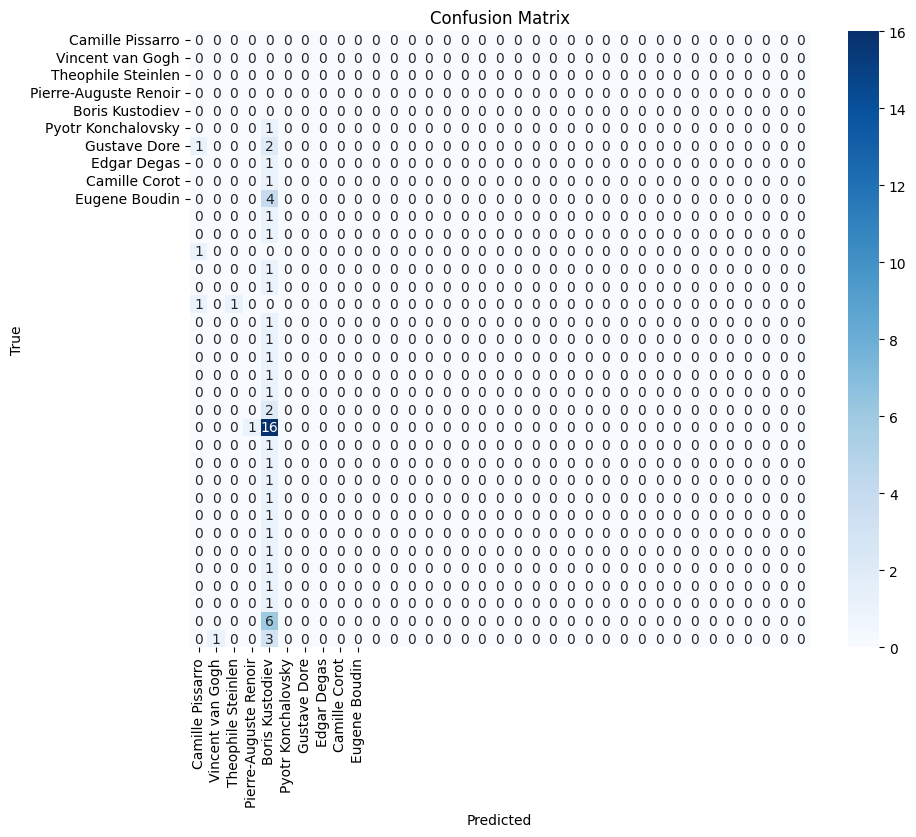

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as pl

test_pred = model_adam.predict(test_gen)

# Convert predicted probabilities to labels
test_pred_labels = np.argmax(test_pred, axis=1)

test_true_labels = test_df['artist']

num_test_samples = test_gen.n
test_true_labels = test_true_labels[:num_test_samples]
test_true_labels = test_true_labels.astype(str)
test_pred_labels = test_pred_labels.astype(str)


print(test_true_labels.shape)
print(test_pred_labels.shape)

# Create a confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(test_true_labels, test_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=training_set_artists, yticklabels=training_set_artists)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



# Evaluate the model 🧐 🤔

In [ ]:
accuracies_adam = []
val_accuracies_adam = []
losses_adam = []
val_losses_adam = []
for hist in histories_adam50:
    if hist:
        accuracies_adam += hist.history['accuracy']
        val_accuracies_adam += hist.history['val_accuracy']
        losses_adam += hist.history['loss']
        val_losses_adam += hist.history['val_loss']

## Plots
### Accuracies

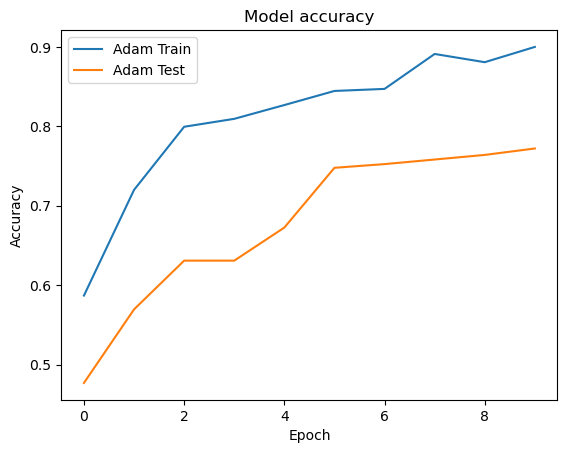

In [ ]:
# Plot training & validation accuracy values
plt.plot(accuracies_adam, label = "Adam Train")
plt.plot(val_accuracies_adam, label = "Adam Test")

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_acc_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_accuracy_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

### Loss values

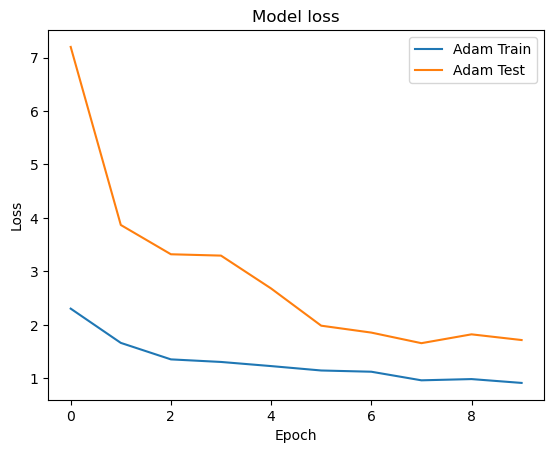

In [ ]:
# Plot training & validation loss values
plt.plot(losses_adam, label = "Adam Train")
plt.plot(val_losses_adam, label = "Adam Test")

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_loss_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_loss_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

### Learning rate

In [ ]:
learning_rates_used = adaptive_lr_scheduler.learning_rates
print("Learning rates per epoch:", learning_rates_used)

Learning rates per epoch: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]


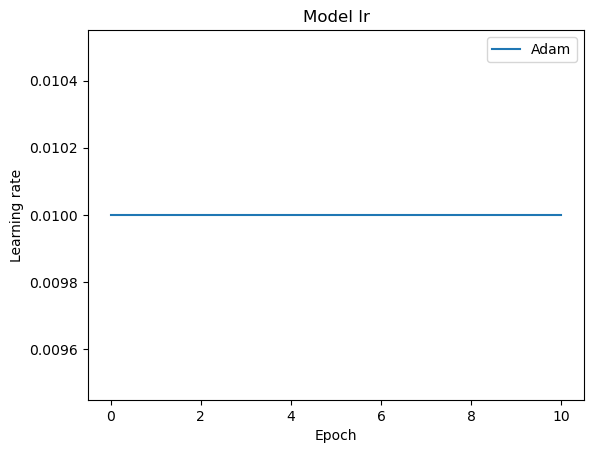

In [ ]:
plt.plot(learning_rates_used, label = "Adam")

plt.title('Model lr')
plt.ylabel('Learning rate')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Predict the output 🔮 🎩

In [ ]:
PRED_STEPS = len(test_gen) # 100 # default would have been len(test_gen)
PRED_STEPS

281

In [ ]:
def retrieve_results(predicted_class_indices, train_gens):
    print(len(predicted_class_indices),"\n",predicted_class_indices)
    print("it has values ranging from ",min(predicted_class_indices),"...to...",max(predicted_class_indices))
    labels = (train_gens[0].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    print("*"*20+"\nclass_indices\n"+"*"*20+"\n",train_gens[0].class_indices,"\n")
    print("*"*20+"\nlabels\n"+"*"*20+"\n",labels,"\n")
    print("*"*20+"\npredictions has", len(predictions),"values that look like","'"+str(predictions[0])+"' which is the first prediction and corresponds to this index of the classes:",train_gens[0].class_indices[predictions[0]])
    # Save the results to a CSV file.
    filenames=test_gen.filenames[:len(predictions)] # because "ValueError: arrays must all be same length"

    real_artists = []
    for f in filenames:
        real = test_df[test_df['new_filename'] == f].artist.to_numpy()[0]
        real_artists.append(real)

    results=pd.DataFrame({"Filename":filenames,
                        "Predictions":predictions,
                        "Real Values":real_artists})
    results.to_csv("results.csv",index=False)

    return results

In [ ]:
def testing_new_images(results, training_set_artists):  
    count = 0
    match = 0
    unexpected_count = 0
    unexpected_match = 0
    match_both_expected_unexpected = 0

    for p, r in zip(results['Predictions'], results['Real Values']):
        if r in training_set_artists:
            count += 1
            if p == r:
                match += 1
        else:
            unexpected_count += 1
            if p == r:
                unexpected_match += 1

    print("test accuracy on new images for TRAINED artists")
    acc = match/count
    print(match,"/",count,"=","{:.4f}".format(acc))

    print("test accuracy on new images for UNEXPECTED artists")
    print("unexpected_match", unexpected_match)
    print("unexpected_count", unexpected_count)
    
    if unexpected_count != 0:
        u_acc = unexpected_match/unexpected_count
        print(unexpected_match,"/",unexpected_count,"=","{:.4f}".format(u_acc))

    print("test accuracy on new images")
    total_match = match+unexpected_match
    total_count = count+unexpected_count
    total_acc = (total_match)/(total_count)
    print(total_match,"/",total_count,"=","{:.4f}".format(total_acc))

## Adam

In [ ]:
# Need to reset the test_gen before calling predict_generator
# This is important because forgetting to reset the test_generator results in outputs with a weird order.
test_gen.reset()
pred_adam = model_adam.predict(test_gen)

281/281 [==============================] - 229s 767ms/step


In [ ]:
print(len(pred_adam),"\n",pred_adam)

10113 
 [[8.04727257e-04 4.04767739e-03 3.89879569e-04 ... 5.35861496e-03
  2.05516844e-05 8.24720628e-05]
 [1.09930761e-05 7.13876216e-04 1.25340803e-03 ... 9.94388130e-04
  3.79198559e-06 2.49061541e-05]
 [1.51381202e-04 8.74841469e-04 3.75820309e-05 ... 6.74502342e-04
  4.13899579e-06 4.49073195e-05]
 ...
 [1.39237553e-01 1.04452565e-01 7.60575582e-04 ... 7.46746222e-03
  5.34233376e-02 2.08907411e-03]
 [1.77956317e-04 6.74847901e-01 6.08954020e-02 ... 8.75055033e-04
  1.24265872e-01 2.19740643e-04]
 [4.03708927e-02 1.24865668e-02 5.25613362e-03 ... 1.17507484e-02
  2.11067483e-01 1.39211980e-03]]


In [ ]:
predicted_class_indices_adam=np.argmax(pred_adam,axis=1)

In [ ]:
results_adam = retrieve_results(predicted_class_indices_adam, train_gens)

10113 
 [4 4 4 ... 5 1 5]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 10113 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


In [ ]:
results_adam.head()

,Filename,Predictions,Real Values
0,32145.jpg,Pablo Picasso,kiri nichol
1,20304.jpg,Pablo Picasso,kiri nichol
2,836.jpg,Pablo Picasso,kiri nichol
3,49823.jpg,Pablo Picasso,Hiroshige
4,84512.jpg,John Singer Sargent,Franz Richard Unterberger


In [ ]:
len(training_set_artists)

10

In [ ]:
testing_new_images(results_adam, training_set_artists)

test accuracy on new images for TRAINED artists


ZeroDivisionError: division by zero

# Ideas
- Having a the prediction dataset: Filename, Predictions, Real Values. We can construct a composition of the predictions.
- We can now predict artist and another caracteristic (like stryle).

## Mosaics

In [ ]:
def calculate_position(current_index, total_images_per_row, image_width, image_height, margin):
    row = current_index // total_images_per_row
    col = current_index % total_images_per_row
    x = col * (image_width + margin)
    y = row * (image_height + margin)
    return (x, y)


### Predictions

In [ ]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10
max_rows = 21  # Maximum number of rows to display

# Create compositions
for predicted_artist, group in grouped_data:
    # Limit the number of images to max_rows * total_images_per_row
    num_images = min(len(group), max_rows * total_images_per_row)
    
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        if i >= num_images:
            break
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/compositions/predictions_13000_images/composition_{}.png'.format(predicted_artist))


### Real values

In [ ]:
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

In [ ]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
filtered_data = results_adam[results_adam['Real Values'].isin(training_set_artists)]
grouped_data = filtered_data.groupby('Real Values')# tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10
max_rows = 21  # Maximum number of rows to display

# Create compositions
for predicted_artist, group in grouped_data:
    # Limit the number of images to max_rows * total_images_per_row
    num_images = min(len(group), max_rows * total_images_per_row)
    
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        if i >= num_images:
            break
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/XNAPproject-grup07/compostions/real_values_13000_images/composition_{}.png'.format(predicted_artist))


Exception in thread SockSrvRdThr:
Traceback (most recent call last):
  File "/anaconda/envs/py38_default/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/service/server_sock.py", line 99, in run
    sreq = self._sock_client.read_server_request()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 274, in read_server_request
    data = self._read_packet_bytes()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 248, in _read_packet_bytes
    rec = self._extract_packet_bytes()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 230, in _extract_packet_bytes
    assert magic == ord("W")
AssertionError
Bad pipe message: %s [b'\xd2\xe9\xa0\xf1I\xb7}r\xe0\x7f\xc0\x83\xc1\xa2A\xa6\xeb\x8e P\xa0f\xb6\xd3\x198\x0e\x8e\xcag\xf0', b'\x19a\x03u\xba\xbe\xfb\x